In [1]:
library(tidyverse)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
edges_df <- read_tsv('../../data/3.all_nodes/ppi.tsv.xz')
full_features <- read_tsv('../../data/4.data/ppi.tsv.xz')
features_df <- read_csv('prediction_features.csv.gz')

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_integer(),
  id_b = col_integer(),
  train = col_integer(),
  test_recon = col_integer(),
  test_new = col_integer(),
  edge_prior = col_double(),
  rwr = col_double(),
  mean_rwr = col_double(),
  p_rwr = col_double(),
  jaccard = col_double(),
  mean_jaccard = col_double(),
  p_jaccard = col_double()
)
Parsed with column specification:
cols(
  id_a = col_integer(),
  id_b = col_integer(),
  adamic_adar_index = col_double(),
  preferential_attachment = col_double(),
  resource_allocation_index = col_double(),
  source = col_integer(),
  target = col_integer()
)


In [3]:
df <- features_df %>%
    left_join(edges_df, by = c("id_a", "id_b")) %>%
    left_join(full_features, by = c("id_a", "id_b", "name_a", "name_b", "train", "test_recon", "test_new"))

head(df, 2)

id_a,id_b,adamic_adar_index,preferential_attachment,resource_allocation_index,source,target,name_a,name_b,train,test_recon,test_new,edge_prior,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
0,1,0.0000000,165,0.0000,55,3,A0A087WT00,A0A0B4J1W7,0,0,0,0,1.582702e-05,1.455860e-05,0.088,0.000000000,0.001491855,1.000
0,2,0.2282049,3520,0.0125,55,64,A0A087WT00,A0AV96,0,0,0,0,7.970098e-05,6.923833e-05,0.250,0.008474576,0.014554941,0.819


In [4]:
vis_df <- df %>%
    sample_n(2000) %>%
    mutate(
        geo_mean_degree = (source * target) ^ 0.5,
        ari_mean_degree = (source + target) / 2
    ) %>%
    gather(key = 'feature', value = 'feature_value', adamic_adar_index:resource_allocation_index, rwr:p_jaccard) %>%
    gather(key = 'degree_side', value = 'degree', source, target, geo_mean_degree, ari_mean_degree) %>%
    mutate(
        degree_side = (
            degree_side %>% 
                recode_factor(source = 'source degree', target = 'target degree',
                              geo_mean_degree = 'geometric mean degree', 
                              ari_mean_degree = 'arithmetic mean degree',)
        )
    ) %>%
    select(-starts_with('name')) %>%
    filter(!grepl('mean_|p_', feature) & feature != 'jaccard_coefficient') 

head(vis_df, 2)

id_a,id_b,train,test_recon,test_new,edge_prior,feature,feature_value,degree_side,degree
1581,3790,0,0,0,0.013,adamic_adar_index,0.6754262,source degree,141
2406,3287,0,0,0,0.003,adamic_adar_index,0.0000000,source degree,16


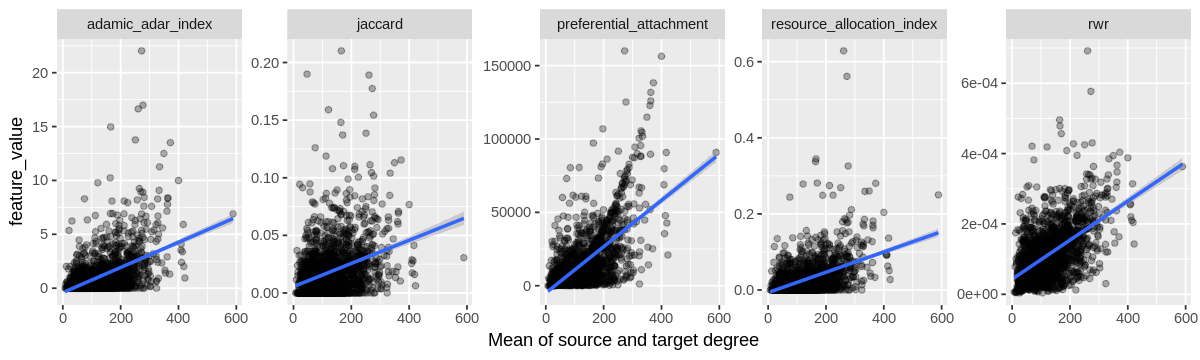

In [5]:
options(repr.plot.width=10, repr.plot.height=3)

scatter_vertical <- (
    ggplot(vis_df %>% filter(degree_side == 'arithmetic mean degree'), aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + facet_grid(rows = vars(feature), scales='free')
)
ggsave(plot = scatter_vertical, height = 10, width = 4,
       filename = '../../img/link_prediction_features_degree_vertical.png')
ggsave(plot = scatter_vertical, height = 10, width = 4,
       filename = '../../../xswap-manuscript/content/images/link_prediction_features_degree_vertical.png')


scatter_horizontal <- (
    ggplot(vis_df %>% filter(degree_side == 'arithmetic mean degree'), aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + facet_wrap(vars(feature), scales='free', nrow = 1)
    + xlab('Mean of source and target degree')
)
ggsave(plot = scatter_horizontal, height = 3, width = 10,
       filename = '../../img/link_prediction_features_degree_horizontal.png')
ggsave(plot = scatter_horizontal, height = 3, width = 10,
       filename = '../../../xswap-manuscript/content/images/link_prediction_features_degree_horizontal.png')
scatter_horizontal

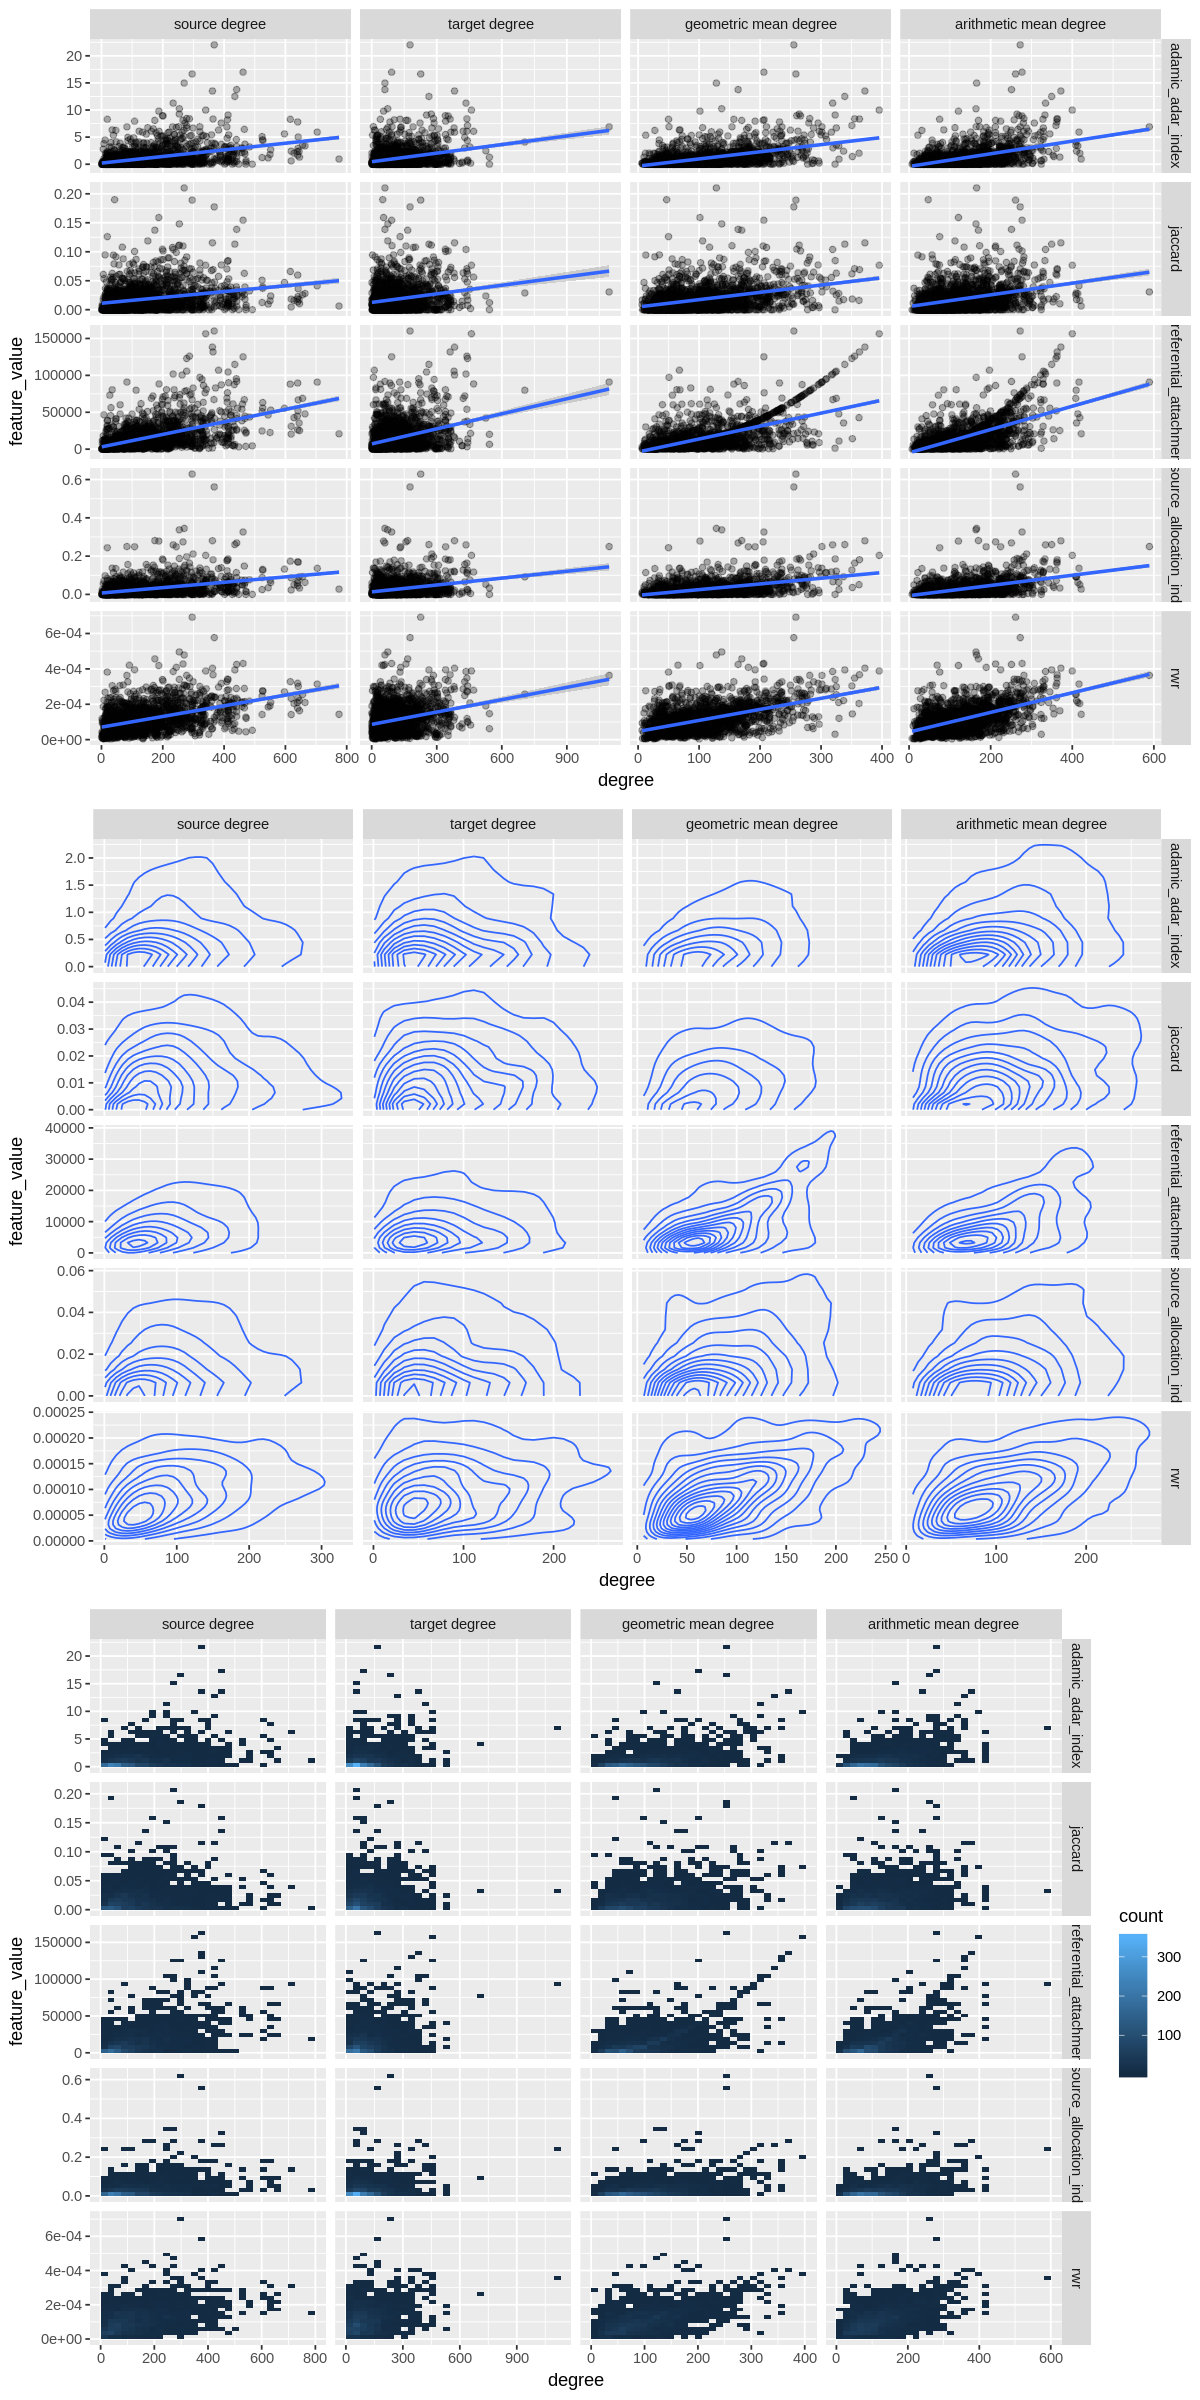

In [6]:
options(repr.plot.width=10, repr.plot.height=20)

scatter <- (
    ggplot(vis_df, aes(x = degree, y = feature_value))
    + geom_point(alpha=0.3)
    + geom_smooth(method='lm')
    + facet_grid(cols = vars(degree_side), rows = vars(feature), scales='free')
)

contour <- (
    ggplot(vis_df, aes(x = degree, y = feature_value))
    + geom_density_2d()
#     + geom_smooth(method='lm')
    + facet_grid(cols = vars(degree_side), rows = vars(feature), scales='free')
)

heatmap <- (
    ggplot(vis_df, aes(x = degree, y = feature_value))
    + geom_bin2d()
#     + geom_smooth(method='lm')
    + facet_grid(cols = vars(degree_side), rows = vars(feature), scales='free')
)

grid.arrange(scatter, contour, heatmap, ncol = 1)